In [149]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import os, re
sns.set()
sns.set_context('talk')
colours = itertools.cycle(sns.color_palette('Set2'))
palettes = itertools.cycle([sns.color_palette('PuBuGn_d'), sns.color_palette('Oranges_d'), sns.color_palette('GnBu_d'), sns.color_palette('Reds_d'), sns.color_palette('Blues_d'), sns.color_palette('PuRd_d')])
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [221]:
def scatterPlotOverTime(data, timestamp_col, y_col, title, regression=True):
    
    x = [d.to_pydatetime() for d in data[timestamp_col]]
    epoch = (data[timestamp_col] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')
    y = [c for c in data[y_col]]

    rp = sns.regression._RegressionPlotter(epoch, y, ci=95)
    min_x = epoch.min()
    max_x = epoch.max()
    grid, yhat, err_bands = rp.fit_regression(x_range=(min_x,max_x))
    grid = grid.astype('datetime64[s]')
    
    sns.scatterplot(x=x, y=y)
    if regression:
        sns.lineplot(grid,yhat)
        plt.fill_between(grid,err_bands[0,:],err_bands[1,:],alpha=.5)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(data[timestamp_col].min()-pd.Timedelta('432000 m'), data[timestamp_col].max()+pd.Timedelta('432000 m'))
    plt.title(title)

## COCA

In [31]:
path = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/COCA/all_years/'
coca_by_genre = [f for f in os.listdir(path) if f.endswith('_all_years.csv')]
coca_wordcount = pd.read_excel('/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/COCA/coca_wordcount.xlsx', header=[1])

coca_file_genre_dict = {
    'fic' : 'Fiction',
    'spok' : 'Spoken',
    'news' : 'News',
    'acad' : 'Academic',
    'mag' : 'Magazine'
}

genre_count_dict = {}
genre_freqmil_dict = {}

for f in coca_by_genre:
    df = pd.read_csv(path+f)
    short_name = f.split('_all_years.csv')[0]
    genre = coca_file_genre_dict[short_name]
    genre_count_dict[genre] = len(df.index)
    ### TODO - check!!!!
    genre_freqmil_dict[genre] = (len(df.index) / coca_wordcount.loc['Grand Total'][short_name.upper()]) * 1000000
#     genre_freqmil_dict[genre] = (len(df.index) / coca_wordcount.loc['Grand Total']['Total']) * 1000000
    
coca_genre_advadj_counts = pd.DataFrame.from_dict(genre_count_dict, orient='index').reset_index().rename(columns={'index' : 'genre', 0 : 'count'})
coca_genre_advadj_freqmil = pd.DataFrame.from_dict(genre_freqmil_dict, orient='index').reset_index().rename(columns={'index' : 'genre', 0 : 'freqmil'})

In [32]:
coca_genre_advadj_freqmil

,genre,freqmil
0,Fiction,539.478157
1,Spoken,328.822620
2,News,554.140071
3,Academic,633.816208
4,Magazine,714.553326


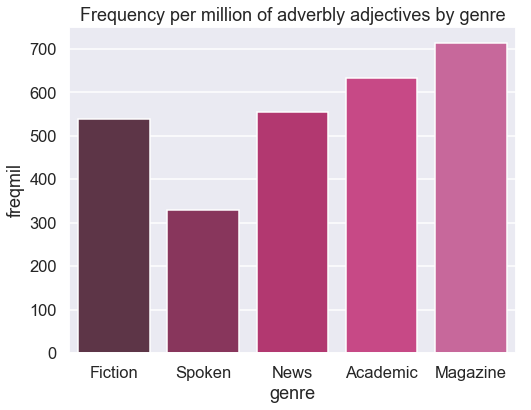

In [184]:
sns.barplot(x='genre', y='freqmil', data=coca_genre_advadj_freqmil, palette=next(palettes))
plt.title('Frequency per million of adverbly adjectives by genre')

In [36]:
path = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/COCA/COCA_smaller_periods/'
coca_by_year = [f for f in os.listdir(path) if re.search('_\d\d\d\d\.csv$', f)]

_coca_advadj_counts = []

for f in coca_by_year:
    df = pd.read_csv(path+f)
    regex = re.search('(\w+)_(\d+)\.csv', f)
    genre = regex.group(1)
    year = regex.group(2)
    
    _coca_advadj_counts.append([coca_file_genre_dict[genre], int(year), len(df.index)])
    
coca_advadj_counts = pd.DataFrame(_coca_advadj_counts).rename(columns={0 : 'genre', 1 : 'year', 2 : 'count'})
coca_advadj_counts['timestamp'] = pd.to_datetime(coca_advadj_counts['year'], format='%Y')

In [38]:
_coca_5year_advadj_freqmil = []

coca_5year_advadj_counts = coca_advadj_counts.groupby('year').sum().reset_index().rename(columns={'index' : 'year', 0 : 'count'})
for index,row in coca_5year_advadj_counts.iterrows():
    year = row['year']
    totals = sum([coca_wordcount['Total'].loc[y] for y in range(int(year),int(year)+5)])
    _coca_5year_advadj_freqmil.append([year, ((row['count'] / totals) * 1000000)])
    
coca_5year_advadj_freqmil = pd.DataFrame(_coca_5year_advadj_freqmil).rename(columns={0 : '5years', 1 : 'freqmil'})
coca_5year_advadj_freqmil['timestamp'] = pd.to_datetime(coca_5year_advadj_freqmil['5years'], format='%Y')

In [61]:
_coca_advadj_freqmil = []

inv_coca_file_genre_dict = {v: k for k, v in coca_file_genre_dict.items()}

grouped = coca_advadj_counts.groupby(['year', 'genre']).sum().reset_index().rename(columns={'index' : 'year', 0 : 'count'})
for index,row in grouped.iterrows():
    count = row['count']
    year = row['year']
    genre = inv_coca_file_genre_dict[row['genre']]
    _coca_advadj_freqmil.append([year,genre,((count / coca_wordcount.loc[year][genre.upper()]) * 1000000)])
    
coca_advadj_freqmil = pd.DataFrame(_coca_advadj_freqmil).rename(columns={0 : 'year', 1 : 'genre', 2 : 'freqmil'})
coca_advadj_freqmil['timestamp'] = pd.to_datetime(coca_advadj_freqmil['year'], format='%Y')

In [62]:
coca_5year_advadj_freqmil

,5years,freqmil,timestamp
0,1990,878.333368,1990-01-01
1,1995,856.931090,1995-01-01
2,2000,867.674915,2000-01-01
3,2005,762.582971,2005-01-01
4,2010,827.417984,2010-01-01


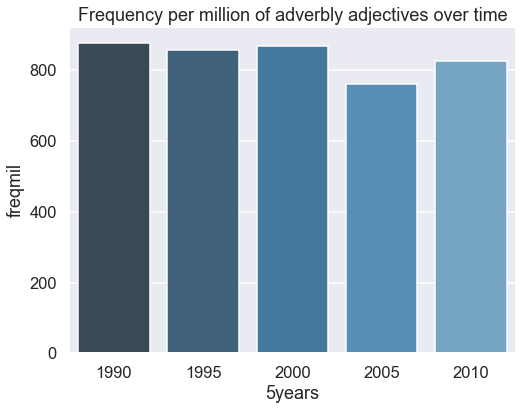

In [178]:
sns.barplot(x='5years', y='freqmil', data=coca_5year_advadj_freqmil, palette=next(palettes))
plt.title('Frequency per million of adverbly adjectives over time')

In [64]:
coca_advadj_freqmil.head()

,year,genre,freqmil,timestamp
0,1990,acad,5354.175736,1990-01-01
1,1990,fic,3480.968203,1990-01-01
2,1990,mag,5819.500095,1990-01-01
3,1990,news,4311.250868,1990-01-01
4,1990,spok,2546.784163,1990-01-01


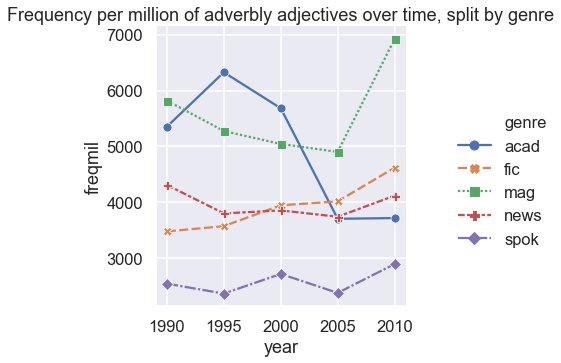

In [179]:
sns.relplot(x='year', y='freqmil', hue='genre', style='genre', data=coca_advadj_freqmil, markers=True, kind='line')
plt.title('Frequency per million of adverbly adjectives over time, split by genre')

In [65]:
path = './POS/'
files_by_genre = [path+d+'/'+f for d in os.listdir(path) if os.path.isdir(path+d) for f in os.listdir(path+d) if f.endswith('.txt') ]

adj_counts = []

for f in files_by_genre:
    regex = re.search('_(\w+)_(\d+)\.txt', f)
    if regex == None:
        raise ValueError(f, 'Improper filename. Must contain substring _<genre>_<year>.txt')
        
    genre = regex.group(1)
    year = regex.group(2)
    df = pd.read_csv(f, encoding='latin1', skiprows=[0], sep='\t', error_bad_lines=False, quoting=3, header=None, index_col=None, names=['word', 'lemma', 'pos'])
    num_adj = len(df[df['pos'].str[0] == 'j'].index)
    adj_counts.append([coca_file_genre_dict[genre], int(year), num_adj])

In [294]:
coca_adj_counts = pd.DataFrame(adj_counts).rename(columns={0 : 'genre', 1 : 'year', 2 : 'count'})
coca_adj_counts['year'] = (np.floor(coca_adj_counts['year'] / 5) * 5).astype(int)
coca_adj_counts = coca_adj_counts.groupby(['genre', 'year']).sum().reset_index()

merged = coca_advadj_counts.merge(adj_counts_df, on=['year', 'genre'], suffixes=['_adv_adj', '_adj'])
coca_advadj_proportion = coca_advadj_counts
coca_advadj_proportion['percentageOfAdjPs'] = merged['count_adv_adj'] / merged['count_adj'] * 100

In [79]:
coca_advadj_proportion.head()

,genre,year,count,timestamp,percentageOfAdjPs
0,Spoken,1995,10418,1995-01-01,0.995634
1,Academic,2005,14295,2005-01-01,0.776870
2,Magazine,2010,24379,2010-01-01,3.109316
3,Magazine,2005,20851,2005-01-01,1.292962
4,Academic,2010,13376,2010-01-01,1.478728


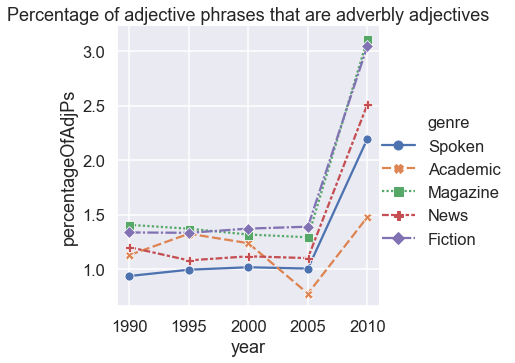

In [175]:
sns.relplot(x='year', y='percentageOfAdjPs', hue='genre', style='genre', data=coca_advadj_proportion, markers=True, kind='line')
plt.title('Percentage of adjective phrases that are adverbly adjectives')

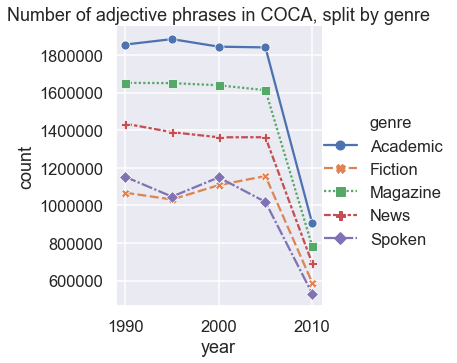

In [180]:
sns.relplot(x='year', y='count', hue='genre', style='genre', data=coca_adj_counts, markers=True, kind='line')
plt.title('Number of adjective phrases in COCA, split by genre')

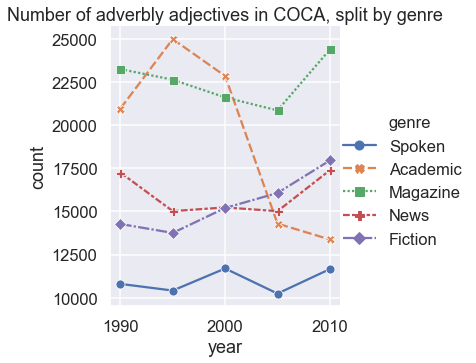

In [181]:
sns.relplot(x='year', y='count', hue='genre', style='genre', data=coca_advadj_counts, markers=True, kind='line')
plt.title('Number of adverbly adjectives in COCA, split by genre')

## CORE

In [91]:
path = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/CORE/data/'
core_by_genre = [f for f in os.listdir(path) if (re.search('CORE_.*\.xlsx$', f) and not(f == 'CORE_allgenres.xlsx'))]

core_wordcount = pd.read_excel('/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/CORE/CORE_summary.xlsx').dropna(subset=['SUBGENRE', 'GENRE'], how='all')[['GENRE', 'TOTAL WORDS']].fillna(method='ffill').groupby('GENRE').sum()

core_file_genre_dict = {
    'opinion' : 'Opinion',
    'htinstr' : 'How-to / Instructional',
    'infodesc' : 'Information Description',
    'narrative' : 'Narrative',
    'infopers' : 'Information Persuason', ### TODO
    'spoken' : 'Spoken',
    'interdisc' : 'Interactive Discussion',
    'lyrical' : 'Lyrical'
}

genre_count_dict = {}
genre_freqmil_dict = {}

for f in core_by_genre:
    df = pd.read_excel(path+f, usecols=[0])
    short_name = f.split('CORE_')[1].split('.xlsx')[0]
    genre = core_file_genre_dict[short_name]
    genre_count_dict[genre] = len(df.index)
    genre_freqmil_dict[genre] = (len(df.index) / core_wordcount['TOTAL WORDS'].loc[genre]) * 1000000
    
core_genre_advadj_counts = pd.DataFrame.from_dict(genre_count_dict, orient='index').reset_index().rename(columns={'index' : 'genre', 0 : 'count'})
core_genre_advadj_freqmil = pd.DataFrame.from_dict(genre_freqmil_dict, orient='index').reset_index().rename(columns={'index' : 'genre', 0 : 'freqmil'})

In [92]:
core_genre_advadj_counts

,genre,count
0,Opinion,22010
1,How-to / Instructional,1881
2,Lyrical,158
3,Information Description,11594
4,Narrative,18427
5,Information Persuason,2007
6,Spoken,1375
7,Interactive Discussion,2949


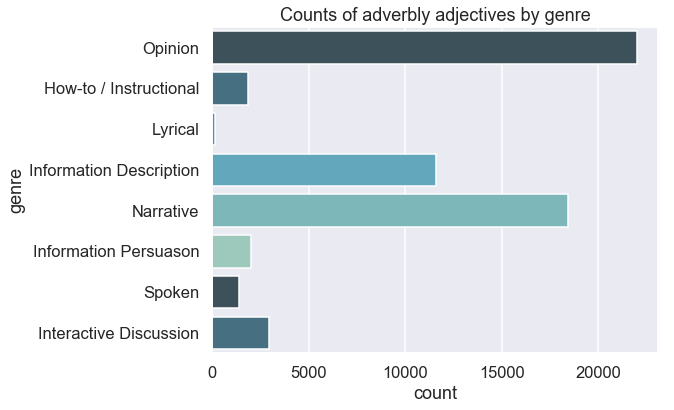

In [193]:
sns.barplot(x='count', y='genre', data=core_genre_advadj_counts, palette=next(palettes), orient='h')
plt.title('Counts of adverbly adjectives by genre')

In [93]:
core_genre_advadj_freqmil

,genre,freqmil
0,Opinion,1533.942859
1,How-to / Instructional,1270.325375
2,Lyrical,627.723944
3,Information Description,1287.146311
4,Narrative,1154.811554
5,Information Persuason,1936.638066
6,Spoken,1742.917733
7,Interactive Discussion,1270.099683


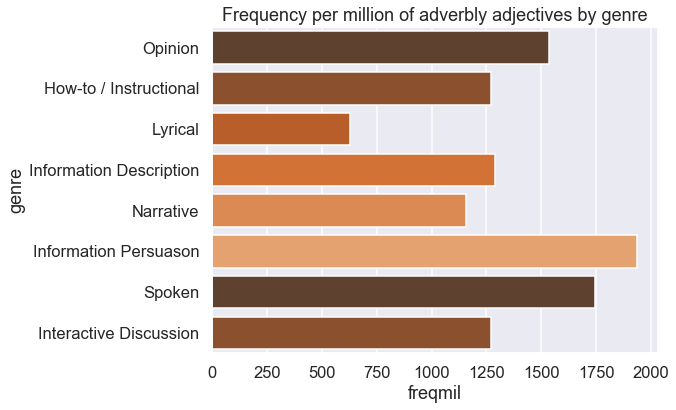

In [192]:
sns.barplot(x='freqmil', y='genre', data=core_genre_advadj_freqmil, palette=next(palettes), orient='h')
plt.title('Frequency per million of adverbly adjectives by genre')

## TIME

In [211]:
path = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/TIME/data/'
time_by_genre = [f for f in os.listdir(path)]

time_wordcount = pd.read_excel('/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/TIME/TIME_summary.xlsx', header=0, sheetname='word count', index_col=0)

year_count_dict = {}
year_freqmil_dict = {}

for f in time_by_genre:
    df = pd.read_table(path+f, skiprows=3, header=None, usecols=[0,1,2,3]).drop([0,1], axis=1)[:-2]
    year = f.split('.txt')[0]
    year_count_dict[year] = len(df.index)
    year_freqmil_dict[year] = (len(df.index) / time_wordcount['# words'].loc[int(year)]) * 1000000
    
time_year_advadj_counts = pd.DataFrame.from_dict(year_count_dict, orient='index').reset_index().rename(columns={'index' : 'year', 0 : 'count'})
time_year_advadj_counts['timestamp'] = pd.to_datetime(time_year_advadj_counts['year'])
time_year_advadj_counts = time_year_advadj_counts[time_year_advadj_counts['year'].astype(int) < 2006]
    
time_year_advadj_freqmil = pd.DataFrame.from_dict(year_freqmil_dict, orient='index').reset_index().rename(columns={'index' : 'year', 0 : 'freqmil'})
time_year_advadj_freqmil['timestamp'] = pd.to_datetime(time_year_advadj_freqmil['year'])
time_year_advadj_freqmil = time_year_advadj_freqmil[time_year_advadj_freqmil['year'].astype(int) < 2006]

In [212]:
time_year_advadj_counts.head()

,year,count,timestamp
0,2002,1744,2002-01-01
1,2003,1699,2003-01-01
2,1939,1977,1939-01-01
3,2001,1969,2001-01-01
4,2000,2279,2000-01-01


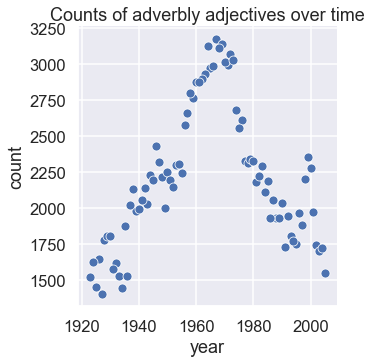

In [209]:
sns.relplot(x='year', y='count', data=time_year_advadj_counts, palette=next(palettes))
plt.title('Counts of adverbly adjectives over time')

In [213]:
time_year_advadj_freqmil.head()

,year,freqmil,timestamp
0,2002,1863.227957,2002-01-01
1,2003,1812.850646,2003-01-01
2,1939,1539.883928,1939-01-01
3,2001,1863.896727,2001-01-01
4,2000,1913.481100,2000-01-01


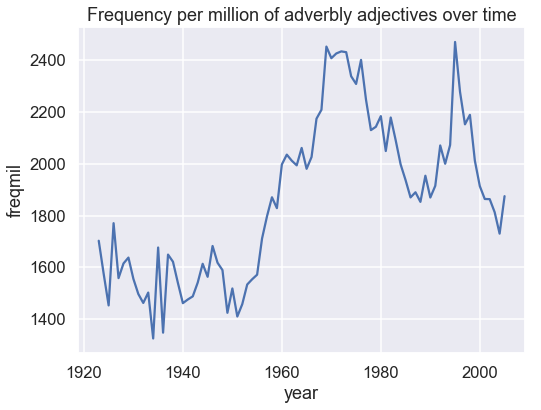

In [231]:
sns.lineplot(x='year', y='freqmil', data=time_year_advadj_freqmil, palette=next(palettes))
plt.title('Frequency per million of adverbly adjectives over time')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


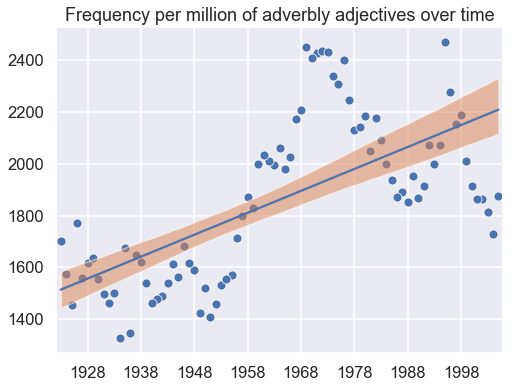

In [224]:
scatterPlotOverTime(time_year_advadj_freqmil, 'timestamp', 'freqmil', 'Frequency per million of adverbly adjectives over time', regression=True)

In [232]:
path = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/TIME/time_adj_counts.csv'
time_adj_counts = pd.read_csv(path)
time_adj_counts['decade'] = (time_adj_counts['decade'].str[:4]).astype(int)

time_decade_advadj_counts = time_year_advadj_counts
time_decade_advadj_counts['decade'] = (np.floor(time_decade_advadj_counts['year'].astype(int) / 10) * 10).astype(int)
grouped = time_decade_advadj_counts.groupby('decade').sum().reset_index().rename({'index' : 'decade'})
merged = grouped.merge(time_adj_counts, on='decade')

time_decade_advadj_proportion = pd.DataFrame(merged['decade'])
time_decade_advadj_proportion['percentageOfAdjPs'] = merged['count'] / merged['adj_count'] * 100
time_decade_advadj_proportion['timestamp'] = pd.to_datetime(time_decade_advadj_proportion['decade'], format='%Y')

In [233]:
time_decade_advadj_proportion.head()

,decade,percentageOfAdjPs,timestamp
0,1920,4.034761,1920-01-01
1,1930,3.606630,1930-01-01
2,1940,3.375508,1940-01-01
3,1950,3.403227,1950-01-01
4,1960,4.457659,1960-01-01


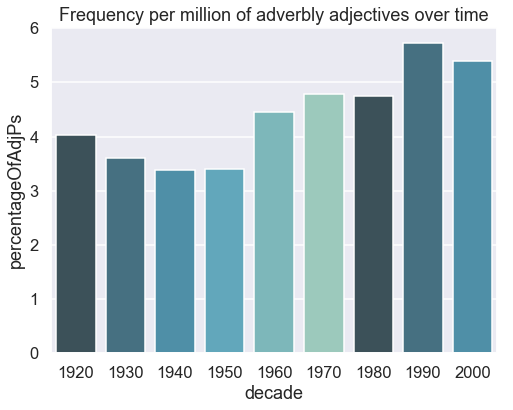

In [217]:
sns.barplot(x='decade', y='percentageOfAdjPs', data=time_decade_advadj_proportion, palette=next(palettes))
plt.title('Frequency per million of adverbly adjectives over time')

## SOCC

In [251]:
path = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Adverbly_adjectives/SOCC/'
advadjs_f = 'socc_advadjs_bymonth.csv'
adjs_f = 'socc_adjs_bymonth.csv'

socc_month_advadj_counts = pd.read_csv(path+advadjs_f, parse_dates=[0])
socc_month_adj_counts = pd.read_csv(path+adjs_f, parse_dates=[0])
merged = socc_month_advadj_counts.merge(socc_month_adj_counts, on='year-month')
socc_month_advadj_proportion = pd.DataFrame(merged['year-month'])
socc_month_advadj_proportion['percentageOfAdjPs'] = merged['adverbly_adjective_count'] / merged['adjective_count'] * 100

In [252]:
socc_month_advadj_proportion.head()

,year-month,percentageOfAdjPs
0,2016-01-01,2.272458
1,2013-10-01,2.338770
2,2014-12-01,2.332960
3,2014-04-01,2.162197
4,2014-09-01,2.083952


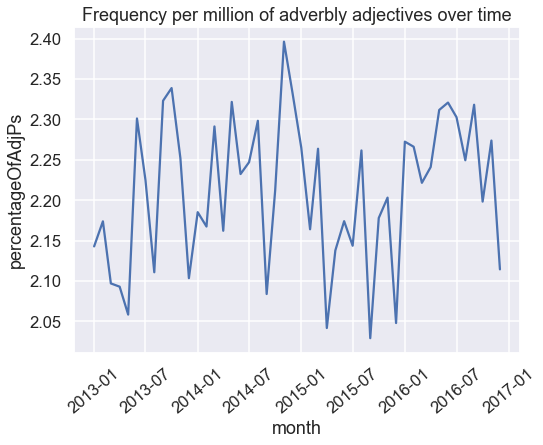

In [259]:
sns.lineplot(x='year-month', y='percentageOfAdjPs', data=socc_month_advadj_proportion, palette=next(palettes))
plt.title('Frequency per million of adverbly adjectives over time')
plt.xticks(rotation=40)
plt.xlabel('month')

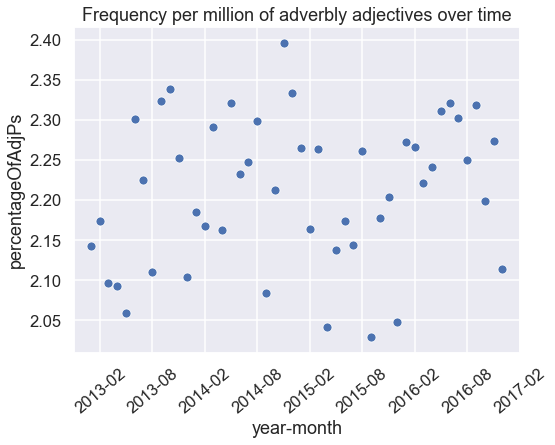

In [281]:
sns.scatterplot(x='year-month', y='percentageOfAdjPs', data=socc_month_advadj_proportion, palette=next(palettes))
plt.title('Frequency per million of adverbly adjectives over time')
plt.xlim(('2012-11-01', '2017-02-01'))
plt.xticks(rotation=40)
plt.show()

## Pie charts

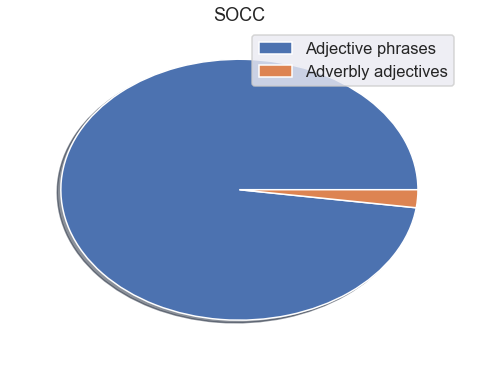

In [293]:
proportions = [socc_month_adj_counts['adjective_count'].sum() - socc_month_advadj_counts['adverbly_adjective_count'].sum(), socc_month_advadj_counts['adverbly_adjective_count'].sum()]
plt.pie(proportions, shadow=True)
plt.legend(['Adjective phrases', 'Adverbly adjectives'])
plt.title('SOCC')
plt.show()

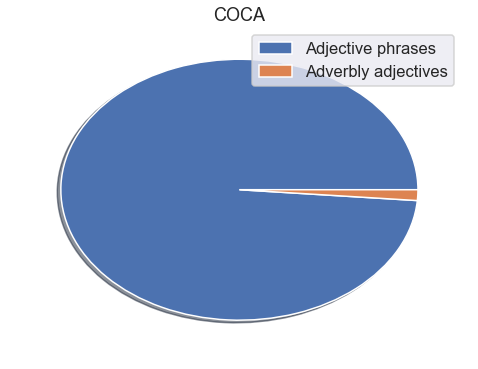

In [297]:
proportions = [coca_adj_counts['count'].sum() - coca_advadj_counts['count'].sum(), coca_advadj_counts['count'].sum()]
plt.pie(proportions, shadow=True)
plt.legend(['Adjective phrases', 'Adverbly adjectives'])
plt.title('COCA')
plt.show()

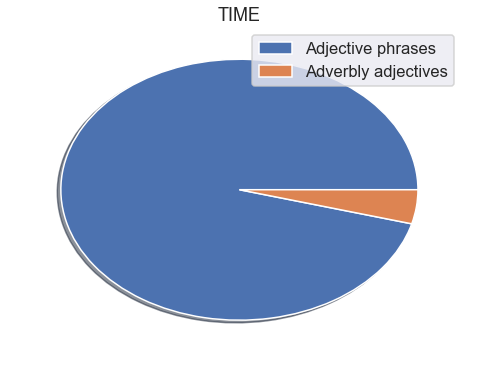

In [302]:
proportions = [time_adj_counts['adj_count'].sum() - time_decade_advadj_counts['count'].sum(), time_decade_advadj_counts['count'].sum()]
plt.pie(proportions, shadow=True)
plt.legend(['Adjective phrases', 'Adverbly adjectives'])
plt.title('TIME')
plt.show()

## Plotting functions

In [262]:
def plotCountByColumn(data, x, y, title, orient='v'):
    if (orient == 'v'):
        sns.barplot(y=y, x=x, data=data, palette=next(palettes), orient=orient)
    else:
        sns.barplot(x=x, y=y, data=data, palette=next(palettes), orient=orient)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.title(title)

In [ ]:
def plotProportionByColumn(data, column, title, orient='v'):
    if (orient == 'v'):
        sns.barplot(y='proportion', x=column, data=data, palette=next(palettes), orient=orient)
    else:
        sns.barplot(x='proportion', y=column, data=data, palette=next(palettes), orient=orient)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.title(title)

## Experimentation

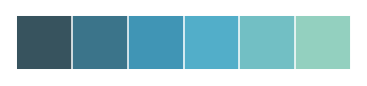

In [131]:
sns.palplot(sns.color_palette("GnBu_d"))

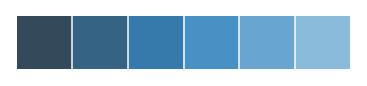

In [132]:
sns.palplot(sns.color_palette("Blues_d"))

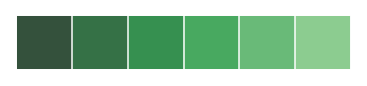

In [133]:
sns.palplot(sns.color_palette("Greens_d"))

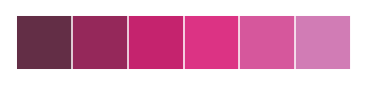

In [146]:
sns.palplot(sns.color_palette("PuRd_d"))

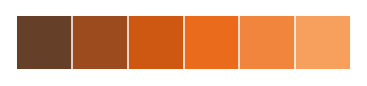

In [135]:
sns.palplot(sns.color_palette("Oranges_d"))

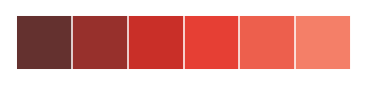

In [136]:
sns.palplot(sns.color_palette("Reds_d"))